# Divvy's Bike Trip Data Exploration
## by Ahmed Aldawody

## Preliminary Wrangling

> This document explores a dataset containing Divvy's bike trip data "Chicago, IL" of the year 2020, It contains about 3541683 rows and 13 columns.

> Data downloaded from https://www.divvybikes.com/system-data.

### Import required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from os import listdir

# set plots to be embedded inline
%matplotlib inline

# set font size for plots
plt.rcParams.update({'font.size': 14})

### Data loading

In [2]:
# Load and join multiple Datasets into pandas DataFrames
df = pd.concat((pd.read_csv(f'data/{f}') for f in listdir("data")))

### Data Inspection

In [37]:
# overview of data
print(df.shape)
df.head(3)

(3541683, 13)


ride_id rideable_type           started_at             ended_at  \
0  EACB19130B0CDA4A   docked_bike  2020-01-21 20:06:59  2020-01-21 20:14:30   
1  8FED874C809DC021   docked_bike  2020-01-30 14:22:39  2020-01-30 14:26:22   
2  789F3C21E472CA96   docked_bike  2020-01-09 19:29:26  2020-01-09 19:32:17   

         start_station_name start_station_id                end_station_name  \
0  Western Ave & Leland Ave              239           Clark St & Leland Ave   
1   Clark St & Montrose Ave              234  Southport Ave & Irving Park Rd   
2    Broadway & Belmont Ave              296        Wilton Ave & Belmont Ave   

  end_station_id  start_lat  start_lng  end_lat  end_lng member_casual  
0          326.0    41.9665   -87.6884  41.9671 -87.6674        member  
1          318.0    41.9616   -87.6660  41.9542 -87.6644        member  
2          117.0    41.9401   -87.6455  41.9402 -87.6530        member

In [6]:
# data types
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

>Cahnge started_at & ended_at to date time type.

In [91]:
# null values count
df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name     94656
start_station_id       95282
end_station_name      110881
end_station_id        111342
start_lat                  0
start_lng                  0
end_lat                 4255
end_lng                 4255
member_casual              0
dtype: int64

>**Null values found in:**
> <ul>
    <li>start_station_name</li>
    <li>start_station_id</li>
    <li>end_station_name</li>
    <li>end_station_id</li>
    <li>end_lat</li>
    <li>end_lng</li>
</ul>

In [5]:
# unique value for each column
print('Duplicates:', df.duplicated().sum(), '\n')
df.nunique()

Duplicates: 0 



ride_id               3541474
rideable_type               3
started_at            3088593
ended_at              3077059
start_station_name        694
start_station_id         1311
end_station_name          694
end_station_id           1310
start_lat              226411
start_lng              221914
end_lat                248888
end_lng                237840
member_casual               2
dtype: int64

>ride_id values are not all unique while no dupicate rows found in the dataset which means there are some rows with same ride_id but different features while it should be unique for each row.

In [94]:
# unique values of rideable_type and meneber_casual columns
print(df.rideable_type.unique())
print(df.member_casual.unique())

['docked_bike' 'electric_bike' 'classic_bike']
['member' 'casual']


>Neither of them is ordered categorical.

>member_casual have 2 values (member or casual), i'll rename it to is_member with value true or false.

### Data Cleaning

In [3]:
# first change member_casual column name to is_member with True or False values
print('n_nulls:', df.member_casual.isna().sum(), '\n')
df.member_casual.value_counts()

n_nulls: 0 



member    2175108
casual    1366575
Name: member_casual, dtype: int64

In [4]:
df.rename(columns={'member_casual': 'is_member'}, inplace=True)
df.is_member = df.is_member == 'member'
df.is_member.value_counts()

True     2175108
False    1366575
Name: is_member, dtype: int64

In [5]:
# next convert date columns to date time type.
df.started_at = pd.to_datetime(df.started_at)
df.ended_at = pd.to_datetime(df.ended_at)

df[['started_at', 'ended_at']].dtypes

started_at    datetime64[ns]
ended_at      datetime64[ns]
dtype: object

**Replace started_at and ended_at columns at trips data frame with:**
<li>duration: duration of a trip in minutes.</li>
<li>month: the month when a trip started.</li>
<li>month_day: the day of the month when a trip started.</li>
<li>week_day: the day of the week when a trip started.</li>
<li>hour: the hour of the day when a trip started.</li>

In [6]:
# add new columns
monthes = ['January', 'February', 'March', 'April', 'May', 'June',
           'July', 'August', 'September', 'October', 'November', 'December']

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df['duration'] = (df.ended_at - df.started_at).dt.total_seconds() / 60
df['month'] = pd.Categorical(df.started_at.dt.month_name(), ordered=True, categories=monthes)
df['month_day'] = df.started_at.dt.day
df['week_day'] = pd.Categorical(df.started_at.dt.day_name(), ordered=True, categories=days)
df['hour'] = df.started_at.dt.hour

In [7]:
# drop started_at, ended_at columns
df = df.drop(columns=['started_at', 'ended_at'], axis=1)

**Add distance column to trips data frame:**
<li>distance: the distance between start and end stations in kilometers.</li>

In [8]:
def calc_distance(row):
    '''
    Function takes a row as input returns distance calculate from latitude and longitude.
    saurce:
    https://gist.github.com/s-heisler/e1548f31319dee864d8c5c522be06760#file-haversine_function-py
    '''
    
    # radius of the Earth
    R = 6373.0 

    # coordinates
    lat1, lon1, lat2, lon2 = map(np.deg2rad,
                                 [row['start_lat'], row['start_lng'],
                                  row['end_lat'], row['end_lng']]
                                )
    
    # change in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
        
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    
    c = 2 * np.arcsin(np.sqrt(a)) 
    distance = R * c
    
    return distance

# add distance column
df['distance'] = calc_distance(df)

In [9]:
# check unique distance values for each pair of stations
g = df.groupby(['start_station_id', 'end_station_id'])
g.nunique().distance.nunique()

140

In [10]:
# some has more than one unique value
# i'll use mean fo each group to replace these values
df.distance = g.distance.transform('mean')
df.groupby(['start_station_id', 'end_station_id']).nunique().distance.nunique()

1

> Now each pair of stations hase one value for distance.

In [11]:
# round distance values to 2
df.distance = df.distance.round(2)
df.distance

0         1.74
1         0.84
2         0.62
3         1.23
4         0.78
          ... 
200269    7.40
200270    5.19
200271    1.46
200272    0.98
200273    4.26
Name: distance, Length: 3541683, dtype: float64

In [78]:
# check distance values where start and end stations are the same
df.query('start_station_id == end_station_id').distance.unique()

array([0.  , 0.01, 0.02, 0.04, 0.03, 0.07, 0.16, 0.05, 0.29, 0.06, 0.11])

In [12]:
# chnage distance to zero for rows where start and end stations are the same
df.distance.loc[df.start_station_id == df.end_station_id] = 0

/home/ahmed/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
#check changes
df.query('start_station_id == end_station_id').distance.unique()

array([0.])

In [81]:
df.head()

ride_id rideable_type        start_station_name start_station_id  \
0  EACB19130B0CDA4A   docked_bike  Western Ave & Leland Ave              239   
1  8FED874C809DC021   docked_bike   Clark St & Montrose Ave              234   
2  789F3C21E472CA96   docked_bike    Broadway & Belmont Ave              296   
3  C9A388DAC6ABF313   docked_bike    Clark St & Randolph St               51   
4  943BC3CBECCFD662   docked_bike      Clinton St & Lake St               66   

                 end_station_name end_station_id  start_lat  start_lng  \
0           Clark St & Leland Ave          326.0    41.9665   -87.6884   
1  Southport Ave & Irving Park Rd          318.0    41.9616   -87.6660   
2        Wilton Ave & Belmont Ave          117.0    41.9401   -87.6455   
3        Fairbanks Ct & Grand Ave           24.0    41.8846   -87.6319   
4           Wells St & Hubbard St          212.0    41.8856   -87.6418   

   end_lat  end_lng  is_member  duration    month  month_day  week_day  hour  \
0  41.9671 -87.6674       True  7.516667  January         21   Tuesday    20   
1  41.9542 -87.6644       True  3.716667  January         30  Thursday    14   
2  41.9402 -87.6530       True  2.850000  January          9  Thursday    19   
3  41.8918 -87.6206       True  8.816667  January          6    Monday    16   
4  41.8899 -87.6343       True  5.533333  January         30  Thursday     8   

   distance  
0      1.74  
1      0.84  
2      0.62  
3      1.23  
4      0.78

In [14]:
# next split columns realated to stations separate data frame

# select only columns related to start station and change their names
start_stations = df.loc[:, ['start_station_id', 'start_station_name', 'start_lat', 'start_lng']]
start_stations = start_stations.rename(columns = lambda x : x[14:] if len(x) > 9 else x[6:])

# select only columns related to end station and change their names
end_stations = df.loc[:, ['end_station_id', 'end_station_name', 'end_lat', 'end_lng']]
end_stations = end_stations.rename(columns = lambda x : x[12:] if len(x) > 7 else x[4:])

print(start_stations.columns)
print(end_stations.columns)

Index(['id', 'name', 'lat', 'lng'], dtype='object')
Index(['id', 'name', 'lat', 'lng'], dtype='object')


In [15]:
# join start and end stations in one data frame called stations
stations = pd.concat((start_stations, end_stations))
len(stations)

7083366

In [84]:
# check unique names for each id
stations_grouped = stations.groupby('id')
stations_grouped.nunique().nunique()

name      2
lat     656
lng     639
dtype: int64

In [85]:
# not all groups have one unique values fo name, lat and lng
# look at some of them
stations.query('id==317').sort_values('id')

id                        name        lat        lng
1224      317         Wood St & Taylor St  41.869200 -87.671000
104665  317.0         Wood St & Taylor St  41.869154 -87.671045
104669  317.0         Wood St & Taylor St  41.869154 -87.671045
104673  317.0         Wood St & Taylor St  41.869154 -87.671045
104681  317.0         Wood St & Taylor St  41.869154 -87.671045
...       ...                         ...        ...        ...
360733  317.0  Wood St & Taylor St (Temp)  41.869402 -87.673540
360735  317.0  Wood St & Taylor St (Temp)  41.869353 -87.673650
360822  317.0  Wood St & Taylor St (Temp)  41.869265 -87.673730
355696  317.0  Wood St & Taylor St (Temp)  41.869265 -87.673730
199720  317.0         Wood St & Taylor St  41.869200 -87.671000

[10055 rows x 4 columns]

In [86]:
# small  differences in names
# as well lat and lng
# simplify using mode for names and mean for lat and lng

stations = stations_grouped.agg(
    name=pd.NamedAgg(column="name", aggfunc=pd.Series.mode),
    lat=pd.NamedAgg(column="lat", aggfunc='mean'),
    lng=pd.NamedAgg(column="lng", aggfunc='mean'))

# round lat, lng values to 2
stations = stations.round(6)

stations

name        lat        lng
id                                                               
2                       Buckingham Fountain  41.876500 -87.620533
3                            Shedd Aquarium  41.867220 -87.615360
4                            Burnham Harbor  41.856252 -87.613331
5                    State St & Harrison St  41.874061 -87.627706
6                            Dusable Harbor  41.886971 -87.612814
...                                     ...        ...        ...
TA1309000066  Ravenswood Ave & Lawrence Ave  41.969091 -87.674229
TA1309000067    Cottage Grove Ave & 51st St  41.803036 -87.606612
WL-008            Clinton St & Roosevelt Rd  41.867125 -87.641072
WL-011             Jefferson St & Monroe St  41.880416 -87.642713
WL-012         Clinton St & Washington Blvd  41.883417 -87.641169

[1323 rows x 3 columns]

In [88]:
# check unique name, lat amd lng for each id
stations.groupby('id').nunique().nunique()

name    1
lat     1
lng     1
dtype: int64

In [22]:
# drop columns related to stations keep ids only
df = df.drop(columns=['start_station_name', 'start_lat', 'start_lng',
                      'end_station_name', 'end_lat', 'end_lng'],
             index=1)

In [23]:
# duration and distance decribe
df.agg({"duration": ["min", "max"], "distance": ["min", 'max']})

duration  distance
min  -29049.966667      0.00
max  156450.400000     48.39

In [24]:
print('duration max value in days:', df.duration.max() /(60 * 24))
print(df.duration.quantile(0.99),  df.duration.quantile(.1))

duration max value in days: 108.64611111111111
158.46666666666667 4.4


> duration has some negative value and other huge values "max value 108 days" which doesn't make sense.

> for simplicity i'll keep values between quantiles 0.99 and 0.1

In [24]:
# filter data off odd duration values
df = df[(df.duration >= df.duration.quantile(0.1)) & (df.duration <= df.duration.quantile(.99))]
df.agg({"duration": ["min", "max"]})

duration
min    4.400000
max  158.466667

In [26]:
# check null values percentage
(df.isna().sum() / len(df)) * 100

ride_id             0.000000
rideable_type       0.000000
start_station_id    2.444946
end_station_id      2.831209
is_member           0.000000
duration            0.000000
month               0.000000
month_day           0.000000
week_day            0.000000
hour                0.000000
distance            3.984955
dtype: float64

In [25]:
# null values percentage is about 4% max
#drop null values
df = df.dropna()

In [27]:
# check ride_id duplicates after filtering the data
df.duplicated(subset='ride_id', keep=False).sum()

0

In [28]:
# drop ride_id columns, they will not be required for this analsis
df = df.drop(columns=['ride_id'])

In [30]:
df.describe()

duration     month_day          hour      distance
count  3.028134e+06  3.028134e+06  3.028134e+06  3.028134e+06
mean   2.274104e+01  1.558181e+01  1.427408e+01  2.370636e+00
std    2.202920e+01  8.799086e+00  4.598776e+00  1.987176e+00
min    4.400000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    9.300000e+00  8.000000e+00  1.100000e+01  1.070000e+00
50%    1.565000e+01  1.500000e+01  1.500000e+01  1.860000e+00
75%    2.725000e+01  2.300000e+01  1.800000e+01  3.210000e+00
max    1.584667e+02  3.100000e+01  2.300000e+01  3.130000e+01

In [31]:
print('stations shape:', stations.shape)
print('df shape:', df.shape)

stations shape: (1323, 3)
df shape: (3028134, 10)


In [32]:
stations.head(3)

name        lat        lng
id                                           
2   Buckingham Fountain  41.876500 -87.620533
3        Shedd Aquarium  41.867220 -87.615360
4        Burnham Harbor  41.856252 -87.613331

In [33]:
df.head(3)

rideable_type start_station_id end_station_id  is_member  duration    month  \
0   docked_bike              239          326.0       True  7.516667  January   
3   docked_bike               51           24.0       True  8.816667  January   
4   docked_bike               66          212.0       True  5.533333  January   

   month_day  week_day  hour  distance  
0         21   Tuesday    20      1.74  
3          6    Monday    16      1.23  
4         30  Thursday     8      0.78

### What is the structure of your dataset?

**Data consistes of 2 dataframes:**
<ul>
    <li>first called df contains 3028134 rows and 10 columns holds informations about trips</li>
        <ul>
            <li>rideable_type: type of pike used in a trip.</li>
            <li>start_station_id: the id of trip start station.</li>
            <li>end_station_id: the id and id of trip end station.</li>
            <li>is_member: True if rider is member and False if casual.</li>
            <li>duration: duration of a trip in minutes.</li>
            <li>month: the month when a trip started.</li>
            <li>month_day: the day of the month when a trip started.</li>
            <li>week_day: the day of the week when a trip started.</li>
            <li>hour: the hour of the day when a trip started.</li>
            <li>distance: the distance between start and end stations in kilometers.</li>
        </ul>
    <li>stations data frame contains 1323 rows and 3 columns</li>
        <ul>
            <li>index(id): station id</li>
            <li>station_name: the name of the station.</li>
            <li>lat, lng: latitude and longitude of starion.</li>
        </ul>
</ul>

### What is/are the main feature(s) of interest in your dataset?
> main features are duration.

> I'm most interested in figuring out How long does the average trip take?


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I expect that time of daym day of week, month of year has effect on trip duration and on each other.

> When are most trips taken in terms of time of day, day of the week, or month of the year??

> Also distance between start and end stations may have effect on trip duration or time.

> As well rideable type and rider type.

> I will also take alook at start and end stations.

## Univariate Exploration

I'll start by looking at the distribution of the main variable of interest: trip duration.

In [34]:
def histplot(col, binsize, data=df, figsize=[8,5], show_mean=True,
             labels=['', ''], xlim=None, scalex=False, xticks=None):
    
    '''Function to plot histogram'''
    plt.figure(figsize=figsize)
    
    if scalex:
        bins = 10** np.arange(0, np.log(data[col].max()) + binsize, binsize)
        plt.xscale('log')
    else:
        bins = np.arange(0, data[col].max() + binsize, binsize)
    
    plt.hist(data[col], bins=bins)
    
    if show_mean:    
        plt.axvline(df[col].mean(), c='g')
        print(data[col].mean())
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    
    if xticks is not None:
        plt.xticks(xticks, xticks)
        
    if xlim is not None:
        plt.xlim(xlim);

**How are the duration of trips distributed?**

22.74103730217896


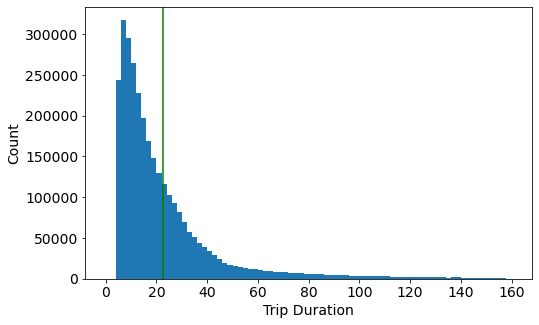

In [35]:
histplot(col='duration', labels=['Trip Duration', 'Count'], binsize=2)

> Trip Duration in avarage is about 23 minutes.

> Histogram is skewed right which make sense that most of trips has short time.

>Try applying log scale on histogram.

**How does the distribution of trip duration look under log scale?**

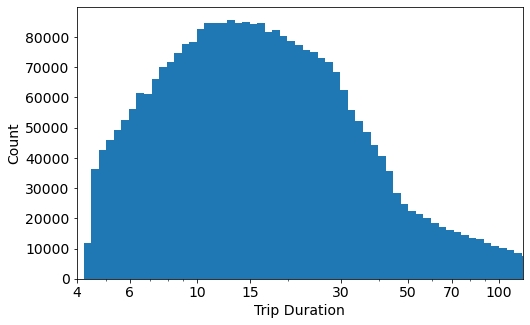

In [36]:
histplot(col='duration', show_mean=False,
         labels=['Trip Duration', 'Count'],
         binsize=.025, scalex=True, xlim=[4, 120],
         xticks=[4, 6, 10, 15, 30, 50, 70, 100])

> When plotted on a log-scale trip duration distribution looks approximately normal with a slight right skew.

**Now i will look at time of day.**

In [227]:
def countplot(col, data=df, xlabel=None, size=[8,5], xticks_rotation=None, hue=None):
    '''Function to plot seaborn countplot'''
    
    main_color = sb.color_palette()[0]

    plt.figure(figsize=size)
        
    sb.countplot(data=data, x=col, hue=hue, color=main_color)
    
    if xticks_rotation is not None:
        plt.xticks(rotation=xticks_rotation, ha='right')
    
    plt.xlabel(col.upper() if xlabel is None else xlabel)
    plt.ylabel('Count')

**Which hour of the day have the most trip counts?**

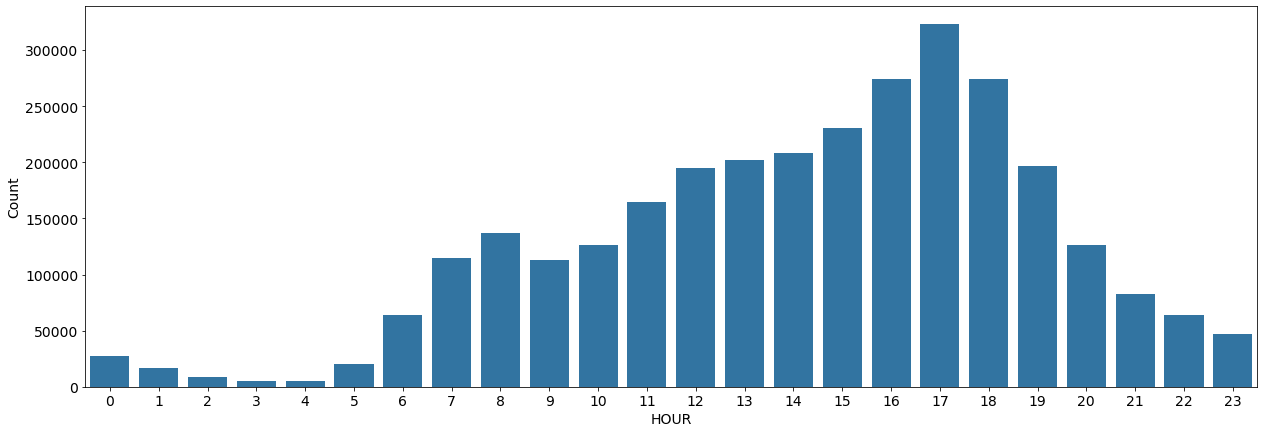

In [228]:
countplot(col='hour', size=[21,7])

>Count distribution is skewed left with max rides at 5pm and min rides at midnight and early morning.

**Which part of the day have the most trip counts?**

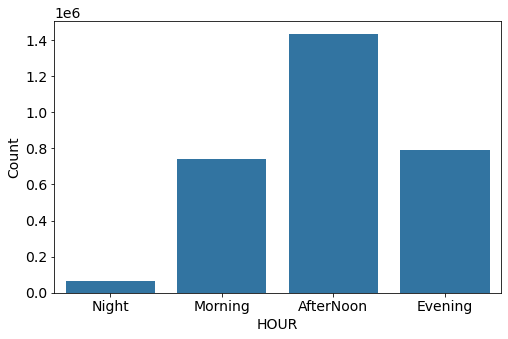

In [293]:
# look at time of the day as parts
# parts of the day
# Morning from (05:00 hours) to (12:00 hours - excluded).
# Afternoon from (12:00 hours) to evening (18:00 hours - excluded).
# Evening from the end of the afternoon (18:00 hours) to midnight (23:00 hours - included).
# Night from the end of the afternoon (20:00 hours) to midnight (05:00 hours - excluded).


bins = [0,4,11,17,23]
labels = ['Night', 'Morning','AfterNoon','Evening']

day_parts = pd.DataFrame(pd.cut(df['hour'], bins=bins, labels=labels, include_lowest=True))

countplot(data=day_parts, col='hour')

>Most of trips are at afternoon, Approximately rqual at morning and eveing, Rarly at night.

**Now i will look at week day.**

**Which day of the week have the most trip counts?**

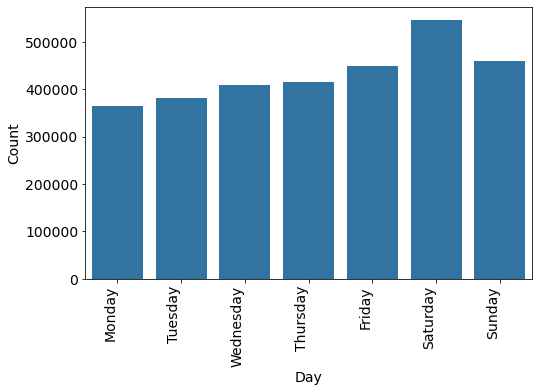

In [121]:
countplot(col='week_day', xlabel='Day', xticks_rotation=90)

> Not much differences in trip counts per day slightly increasing towards weekend with max rides at saturday.

**Next up, months.**

**Which month have the most trip counts?**

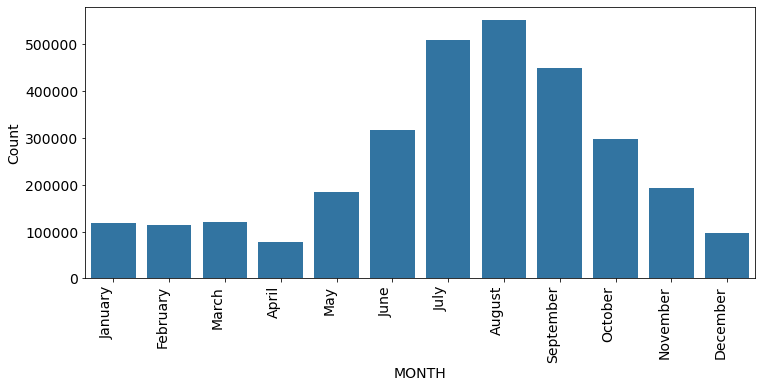

In [122]:
countplot(col='month', size=[12, 5], xticks_rotation=90)

> Count distribuation is skewed left, highly concentrated and approximately normally distributed around august in between april to decemper, i suspect it is due to the weather cold months have less rides.

**Next up, days of month.**

**How does Trips count change over the month?**

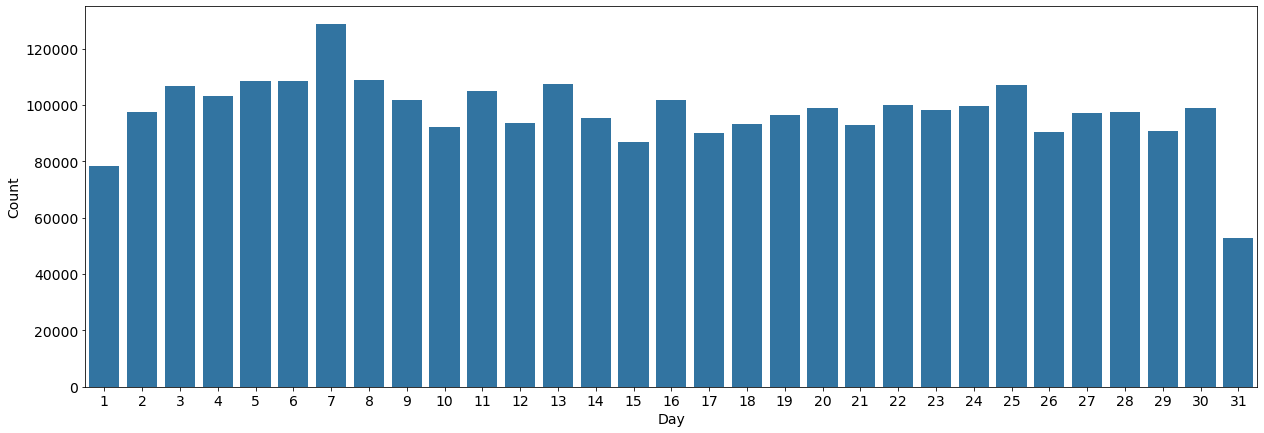

In [123]:
countplot(col='month_day', xlabel='Day', size=[21,7])

> Trips counts decreased by little at the start and end of the month, with some differences in each day, However i suspect that it highly depends on which day of the week is that day.

**Next up, distances between start and end stations.**

**How are the distances between stations distributed?**

2.3706363291714716


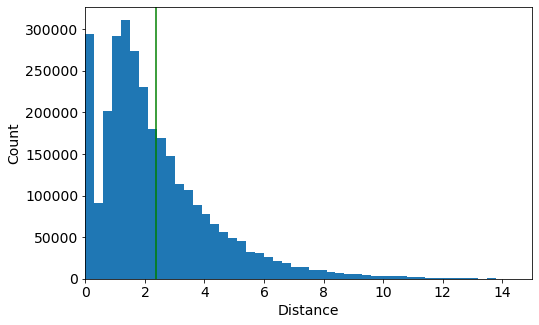

In [72]:
histplot(col='distance', labels=['Distance', 'Count'], binsize=.3, xlim=[0,15])

> The distance between the start and end stations in avarage is about 2.4 kilometer.

> Histogram is skewed right with a long tail.

>Try applying log scale on histogram.

**How does the distribution of the distances between stations look under log scale?**

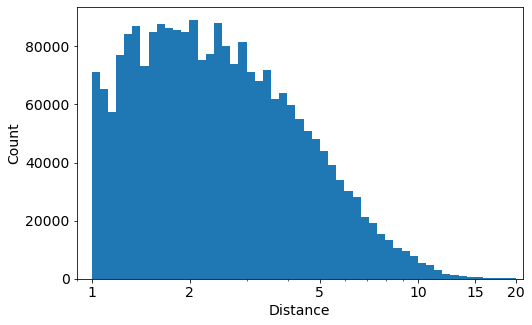

In [73]:
histplot(col='distance', show_mean=False,
         labels=['Distance', 'Count'],
         binsize=.025, scalex=True, xlim=[.9, 21],
         xticks=[1, 2, 5, 10, 15, 20])

> When plotted on a log-scale distances distribution still right skewed but with small tail.

**Next up, rider type.**

In [76]:
def pieplot(col, data=df, labels=None, size=6, angel=90):
    '''Function to plot pie chart'''
    counts = (data[col].value_counts())
    print(counts)

    fig = plt.figure(figsize=[size, size])
    style = plt.get_cmap('Set2').colors
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=style, startangle=angel)

**Which types of users found more in the data?**

True     1814994
False    1213140
Name: is_member, dtype: int64


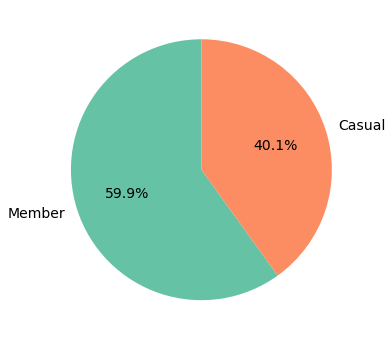

In [78]:
pieplot(col='is_member', labels=['Member', 'Casual'])

> About 60% of trips in the dataset were by a member.

**Next up, ridable type.**

**What is the most favorite type of bikes.**

docked_bike      2657794
electric_bike     310483
classic_bike       59857
Name: rideable_type, dtype: int64


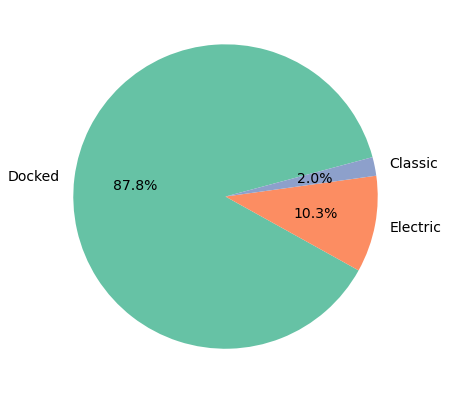

In [79]:
# plotting satisfaction_level on a standard scale
pieplot(col='rideable_type', labels=['Docked', 'Electric', 'Classic'], size=7, angel=15)

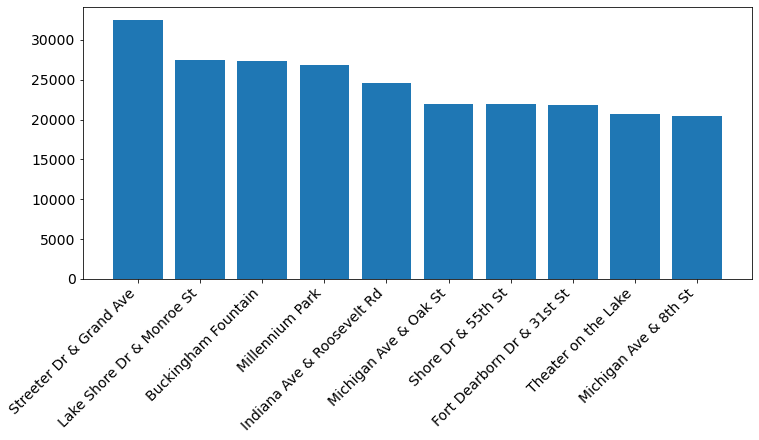

In [199]:
# top 10 start station
stations['nstart'] = df.start_station_id.value_counts()

color = sb.color_palette()[0]
plt.figure(figsize=[12,5])
sb.barplot(data=stations.nlargest(10, 'nstart'), x='name', y='nstart', color=color)
plt.xlabel('Station')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show();

**What are the top 10 "end stations" in term of total trips?**

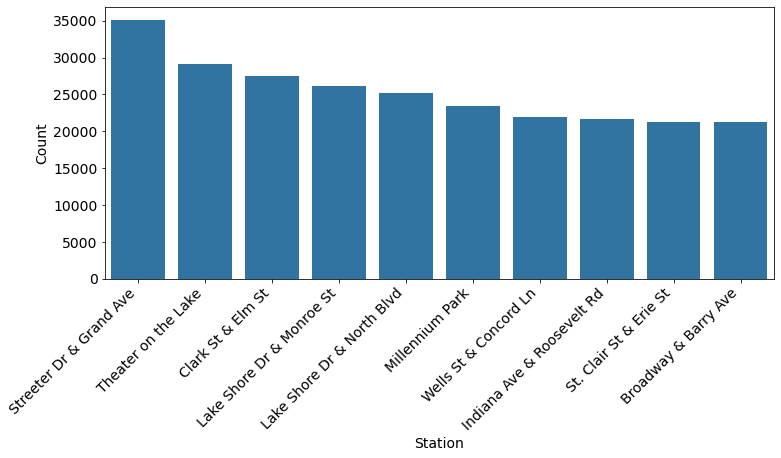

In [64]:
# top 10 end station
stations['nend'] = df.end_station_id.value_counts()

plt.figure(figsize=[12,5])
sb.barplot(data=stations.nlargest(10, 'nend'), x='name', y='nend', color=color)
plt.xlabel('Station')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right');
plt.show();

**What are the top 10 stations had both the srart and end of a trip in term of total trips?**

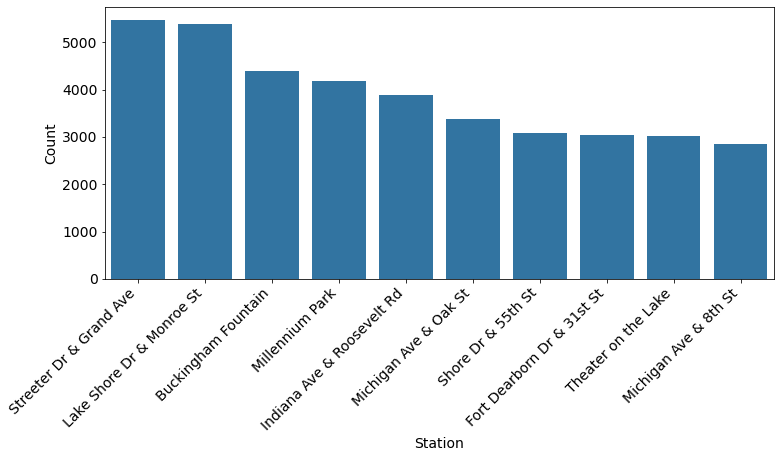

In [65]:
# top 10 stations was the start and end of trip
stations['nboth'] = df.query('start_station_id == end_station_id').start_station_id.value_counts()

color = sb.color_palette()[0]
plt.figure(figsize=[12,5])
sb.barplot(data=stations.nlargest(10, 'nboth'), x='name', y='nboth', color=color)
plt.xlabel('Station')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show();

> Top 5 stations were also the same in start and end cases, also there are some stations with very low count in the dataset.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The duration variable distribution was skewed with long right tail, Most of trips took some minutes with avarage about 24 minute, Under the log scale the distribution looked  approximately normal with a slight right skew.

> The hour variable distribuation was skewed left with max counts at 5pm,  Most of trips are at afternoon, Approximately at morning and eveing, Rarly at night.

> The week_day variable didn't has much differences in counts per day slightly increasing towards weekend with max counts at saturday.

> The month variabl Count distribuation was skewed left, highly concentrated and approximately normally distributed around august in between april to decemper, i suspect it is due to the weather "cold months have less rides".


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Most of operation to clean, tidy, adjust and change form of the data was done befor i select features to study because the initial features in the dataset was row and not much useful so i did the following:
><ul>
    <li>changed member_casual column name to is_member with values(True or False).</li>
    <li>converted row start and end times of ride to (duration, hour, month, week day, month day).</li>
    <li>converted row latitude and longitude of start and end stations to distance.</li>
    <li>Moved columns with informations about stations to seprate dataframe keeping only ids in the original.</li>
    <li>removed odd values of new duration column and removed null values.</li>
    <li>examined duration and distance histograms under the log scale.</li>
    <li>Due to the huge unique values of station names i examined the top and lowest start and end stations.</li>
</ul>


## Bivariate Exploration

> First I want to look at the pairwise correlations present between features in the data.

**What is the correlation of the duration of a trip and the distance between start and end stations?**

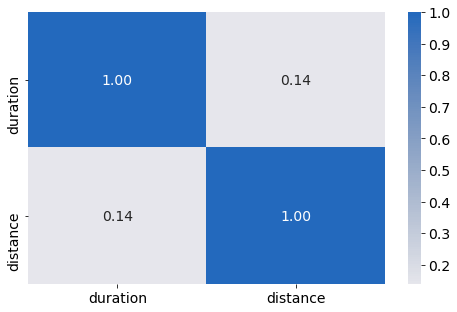

In [149]:
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(df[['duration', 'distance']].corr().round(2), annot = True, fmt = '.2f',
           cmap = 'vlag_r', center = 0);

> No high correlation found between duration and distance.

**How are the duration of a trip and the distance between start and end stations related?**

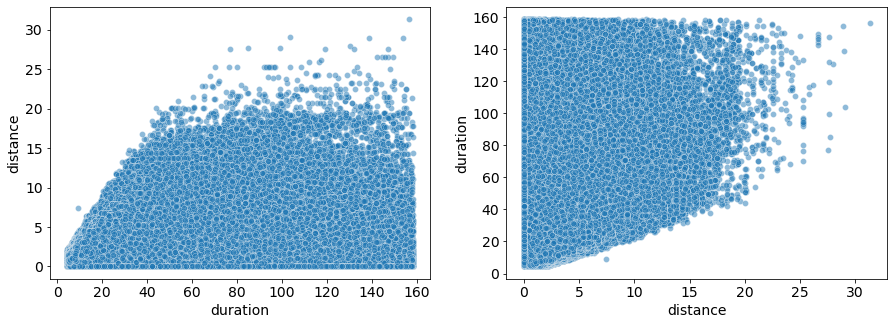

In [139]:
plt.figure(figsize=[15,5])
plt.subplot(1, 2, 1)
sb.scatterplot(data=df, x='duration', y='distance', alpha=.5);

plt.subplot(1, 2, 2)
sb.scatterplot(data=df, y='duration', x='distance', alpha=.5);

> Duration and distance not much related.

**Let's move on to looking at how duration week_day, month and hour correlate with the categorical variables.**

**Start with duration.**

> No high correlation found between duration and distance.

**Let's move on to looking at how duration week_day, month and hour correlate with the categorical variables.**

**Start with duration.**

In [180]:
def mixedplot(x, y, data=df, size=[18,6], xticks_rotation=None, vertical=False):
    '''Function to plot seaborn boxplot and violin plots horizontally or vertically.'''
    color = sb.color_palette()[0]
    
    plt.figure(figsize=size)
    
    a , b = 1 ,2
    
    if vertical:
        a=2
        b=1
    
    plt.subplot(a, b, 1)
    sb.boxplot(data=data, x=x , y=y , color=color)
    if xticks_rotation is not None:
        plt.xticks(rotation=xticks_rotation, ha='right')

    plt.subplot(a, b, 2)
    sb.violinplot(data=data, x=x , y=y , color=color)
    if xticks_rotation is not None:
        plt.xticks(rotation=xticks_rotation, ha='right')

**How does the duration of a trip differ by the types of bike**

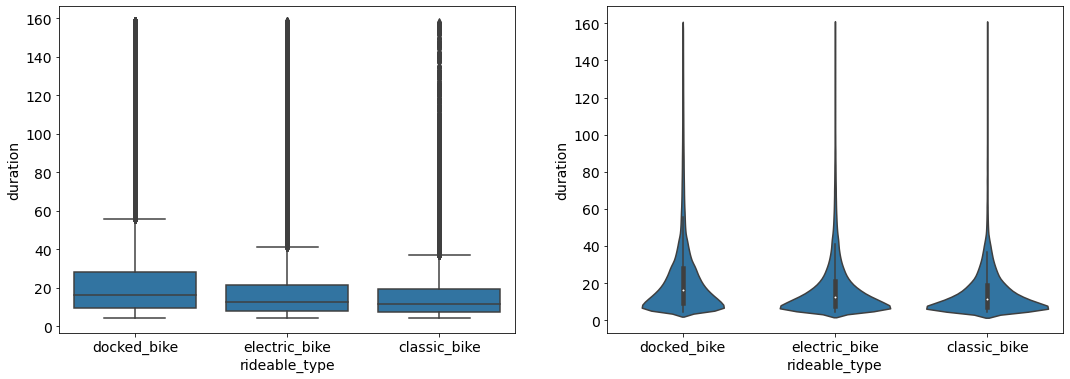

In [181]:
# duration and rideable_type
mixedplot(x='rideable_type', y='duration')

> Trips with docked bikes have higher average duration than electric bikes and classic bike.

**Which types of users tend to have longer trips?**

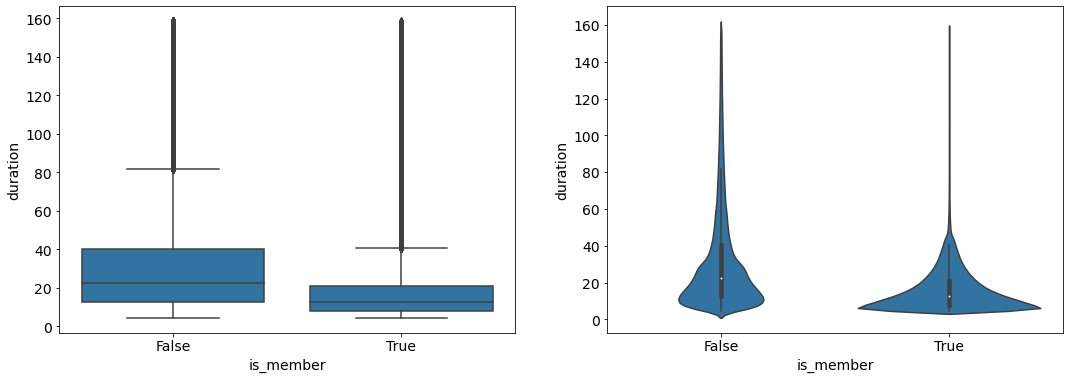

In [165]:
# duration and is_member
mixedplot(x='is_member', y='duration')

> Casual riders have higher average duration in their trips than members.

**How does the duration of a trip differ through the year?**

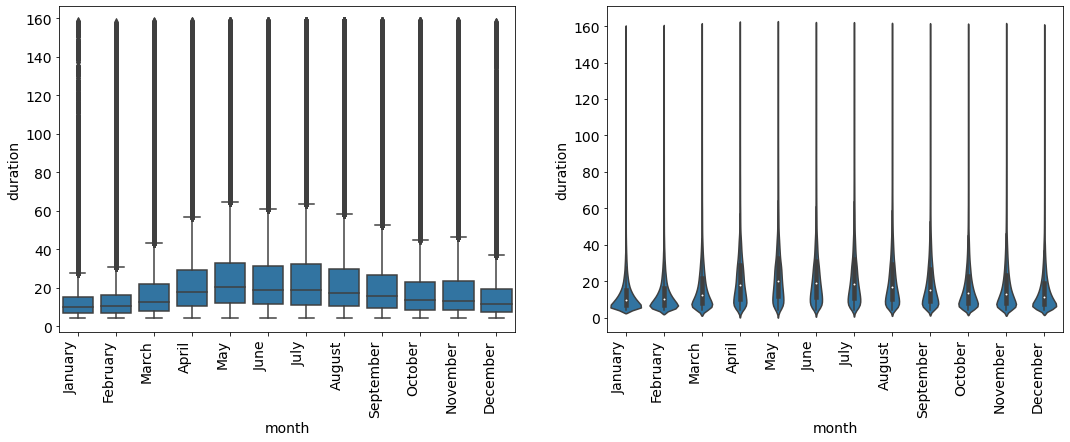

In [175]:
# duration and month
mixedplot(x='month', y='duration', xticks_rotation=90)

> Trip Average duration highly increases in the summer.

**How does the duration of a trip differ through the week?**

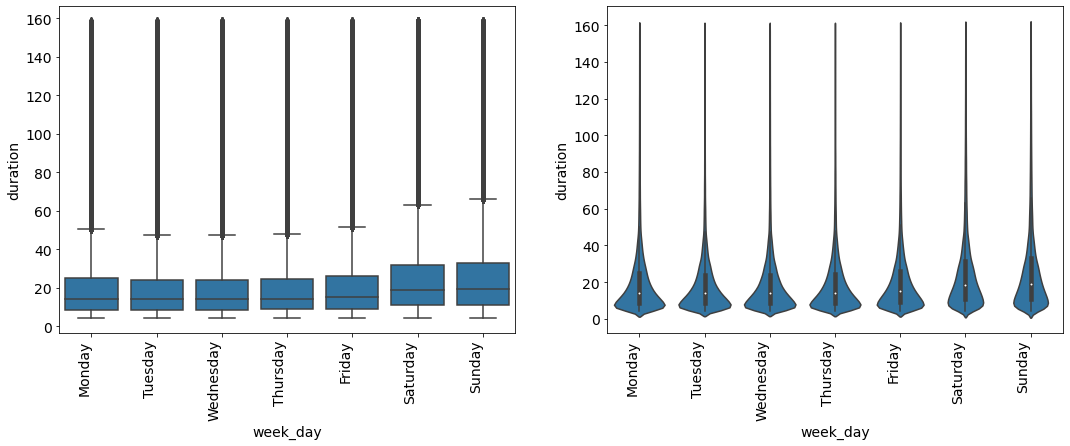

In [176]:
# duration and week_day
mixedplot(x='week_day', y='duration', xticks_rotation=90)

> Trip average duration slightly increases at weekend.

**How does the duration of a trip differ through the month?**

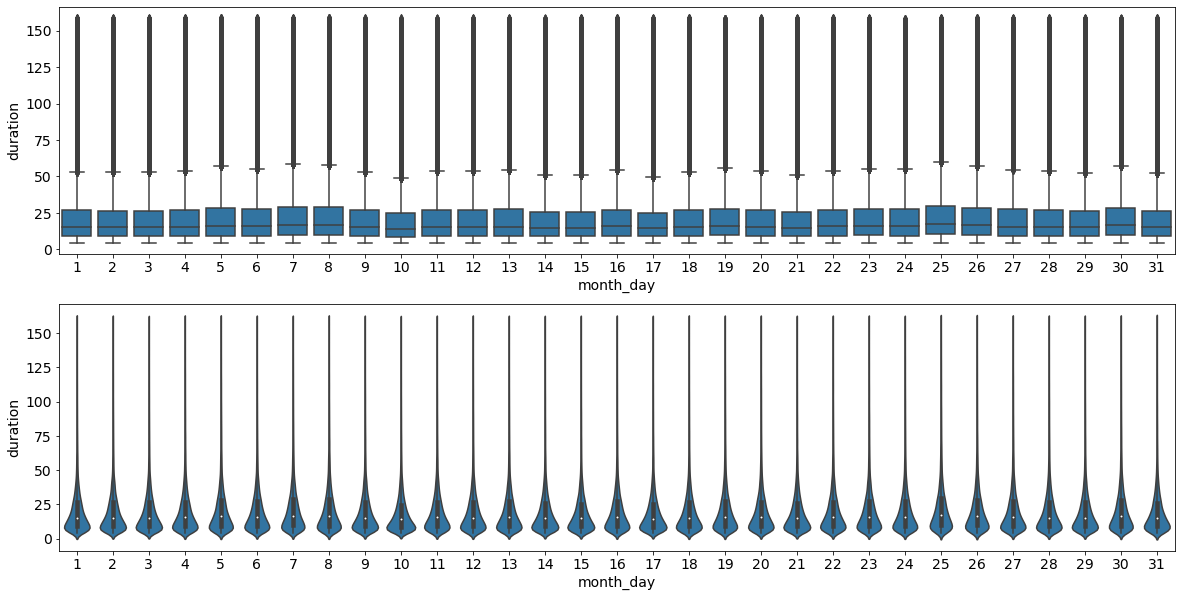

In [185]:
# duration and month_day
mixedplot(x='month_day', y='duration', vertical=True, size=[20,10])

> Day of month doesn't have much effect on trips average duration.

**How does the duration of a trip differ through the day?**

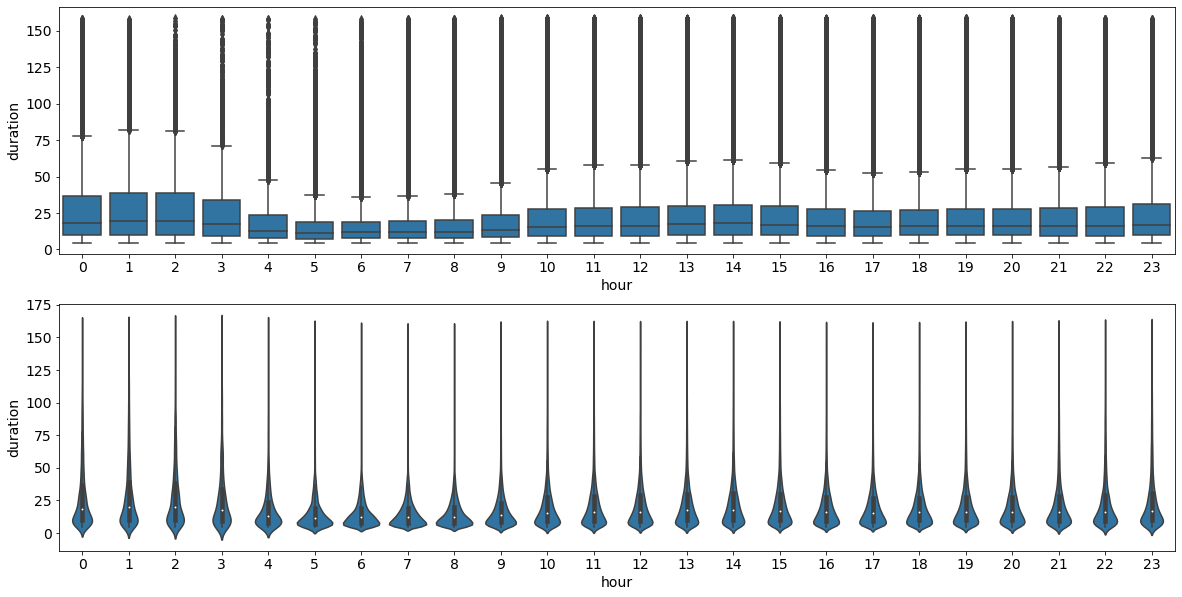

In [187]:
# duration and hour
mixedplot(x='hour', y='duration', vertical=True, size=[20,10])

>Early hours of the morning has the shortest trips.

**Which part of the day has longer trips?**

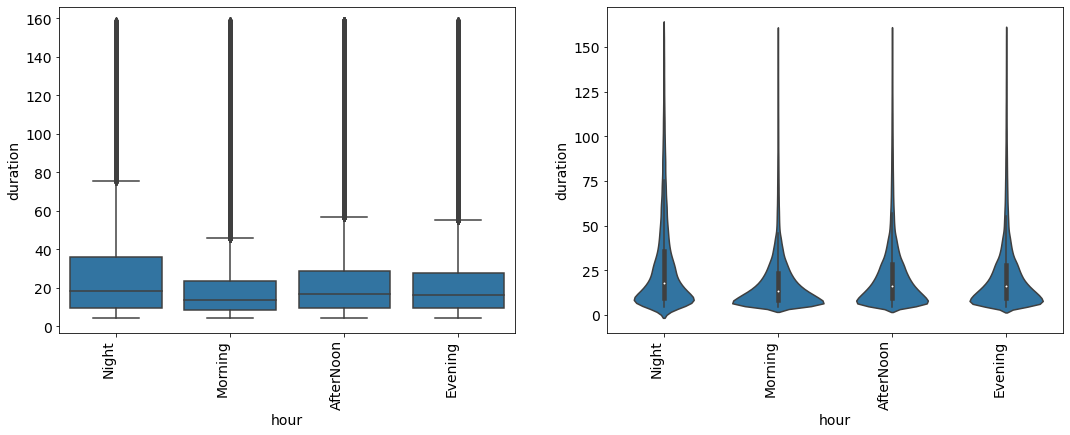

In [197]:
day_parts['duration'] = df.duration
mixedplot(data=day_parts, x='hour', y='duration', xticks_rotation=90)

>Trips at at midnight(22pm to 3 am) has the highest average duration of the day it drops from 4am to 9 am and start increasing at 10am till it reachs its beak at midnight.

**How does the counts of trips change through the week by the type of bike?**

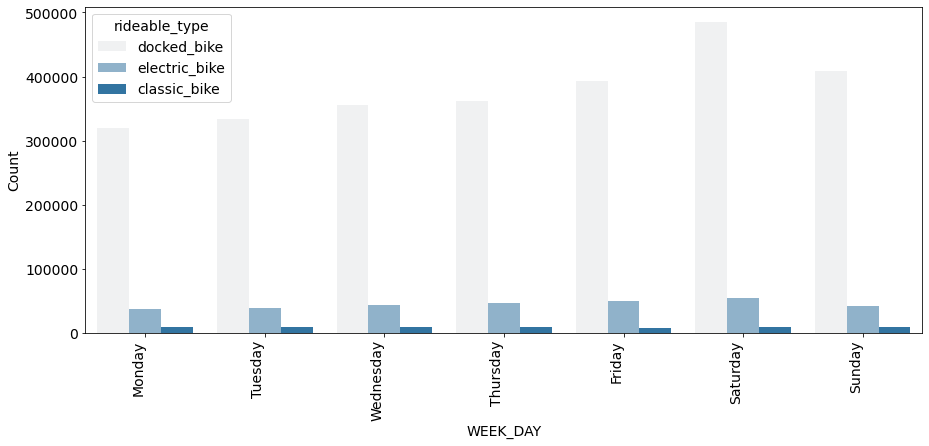

In [231]:
# week_day and rideable_type
countplot('week_day', xticks_rotation=90, hue='rideable_type', size=[15,6])

> There doesn't seem to be that much interaction between week_day and rideable_type.

**Does different types of riders tend to favor specific week day to have a trip?**

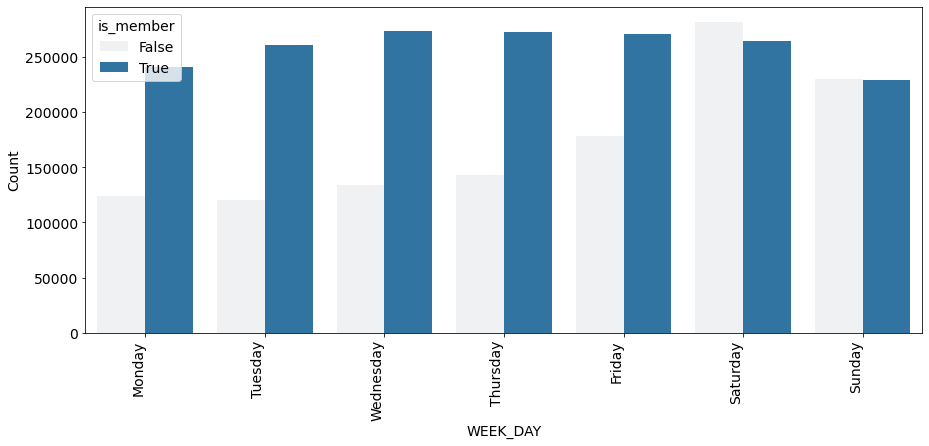

In [233]:
# week_day and is_member
countplot('week_day', xticks_rotation=90, hue='is_member', size=[15,6])

> Casual bikers activity increases by week end while members activity approximately the same with slight incrase in midweek

**How does the counts of trips change through the year by the type of bike?**

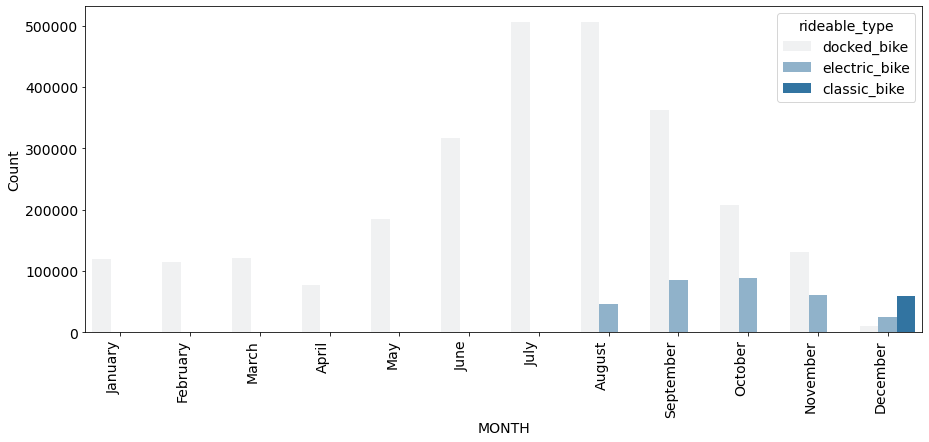

In [236]:
# month and rideable_type
countplot('month', xticks_rotation=90, hue='rideable_type', size=[15,6])

>Electric bikes have more appearances by the end of the year, while in Dec they classic bikes have the most count, However in general Docked bike have the most counts.

**Does different types of riders tend to favor specific month to have a trip?**

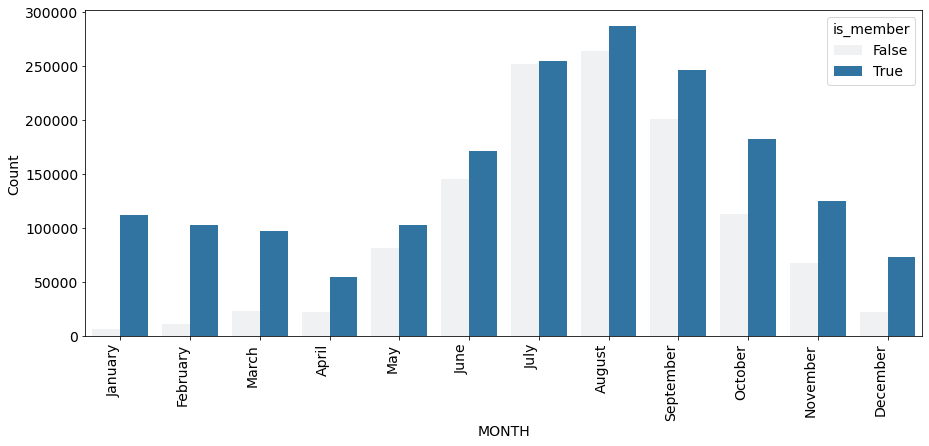

In [237]:
# month and is_member
countplot('month', xticks_rotation=90, hue='is_member', size=[15,6])

>In summer starting from May till September member and casual bikers almost have the same counts especially in July, while casual bikers counts decreased by much in the remaining months.

**How does the counts of trips change through the day by the type of bike?**

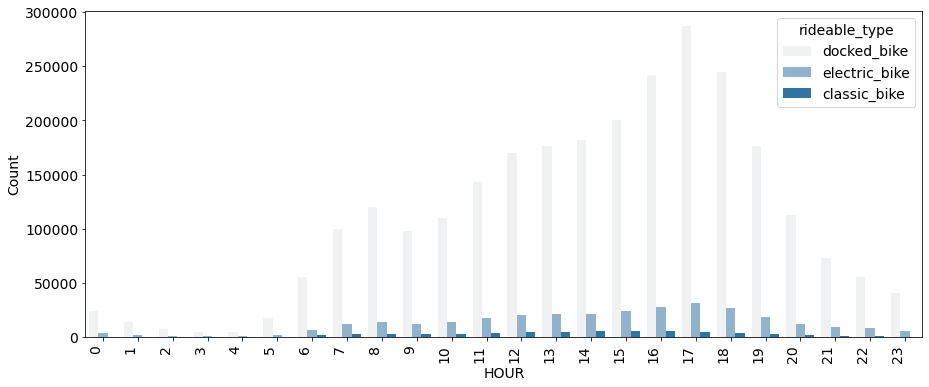

In [238]:
# hour and rideable_type
countplot('hour', xticks_rotation=90, hue='rideable_type', size=[15,6])

**Does choosing a type of bike depends on which part of the day a trip is?**

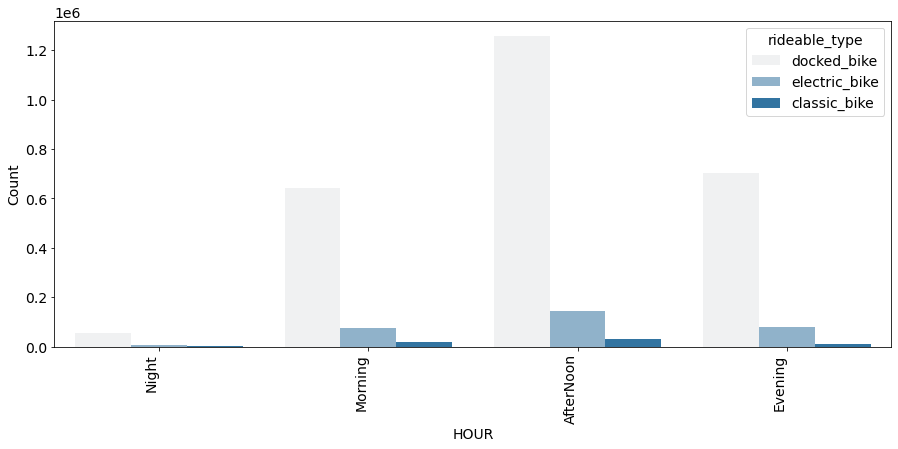

In [269]:
day_parts['rideable_type'] = df.rideable_type
countplot('hour', data=day_parts, xticks_rotation=90, hue='rideable_type', size=[15,6])

> There doesn't seem to be that much interaction between hour and rideable_type.

**How does the counts of trips change through the day by the type of rider?**

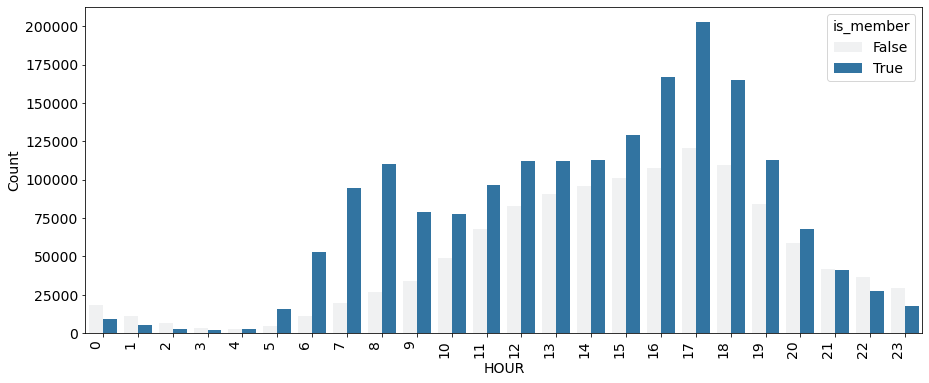

In [239]:
# hour and is_member
countplot('hour', xticks_rotation=90, hue='is_member', size=[15,6])

**Does different types of riders tend to favor specific part of the day to have a trip?**

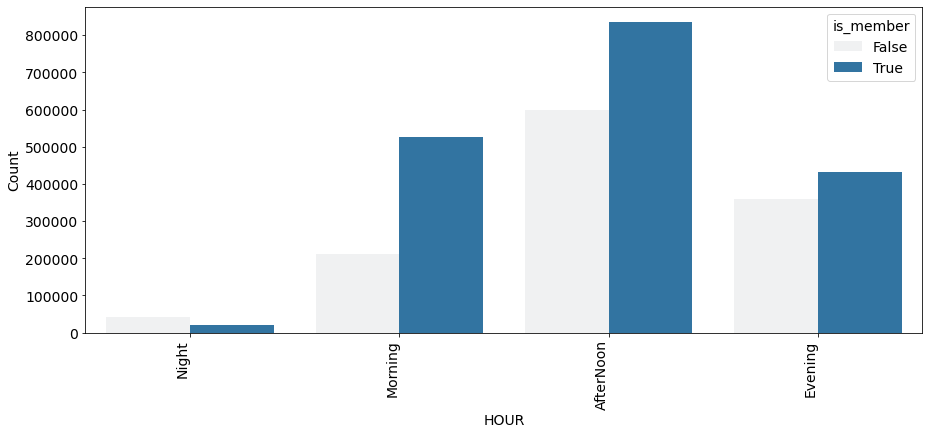

In [270]:
day_parts['is_member'] = df.is_member
countplot('hour', data=day_parts, xticks_rotation=90, hue='is_member', size=[15,6])

>Among the few riders that go in night casual bikers are the most, while members have more counts in day hours.

**Does choosing a specific type of bike varies by the type of rider?**

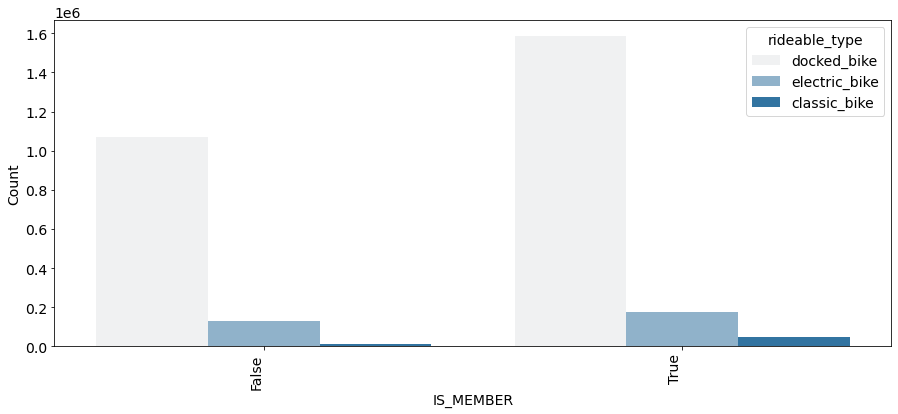

In [243]:
# is_member and rideable_type
countplot('is_member', xticks_rotation=90, hue='rideable_type', size=[15,6])

> There doesn't seem to be that much interaction between is_member and rideable_type.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

>Casual riders surprisingly had longer rides more than members in average. Also trips with docked bikes have higher average duration than electric bikes and classic bike.

>Trip Average duration highly increases in summer months that could be because of warm weather encourage people to go out more, Trip average duration also slightly increases at weekends.

>Among the few riders that go in night casual bikers are the most at midnight(22pm to 3 am) has the highest average duration of the day.

>Not much interaction between duration and(distance and day of month).


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

>Casual bikers activity increases in summer, week ends  and  nights.

>In general Docked bike have the most counts, while electric bikes have more appearances by the end of the year, while surprisingly in Dec they classic bikes have the most count, However .

## Multivariate Exploration

> The main thing I want to explore in this part of the analysis is how the rider and rideable types play into the relationship between trip duration and time in terms of month, week day and day part.

**What is the average duration of a trip per bike and rider types?**

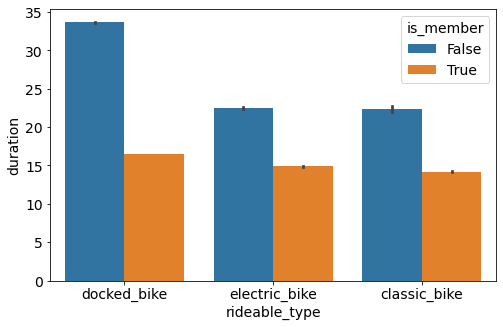

In [263]:
# first relation between duration and biker and bike types
plt.figure(figsize=[8,5])
sb.barplot(data = df, x = 'rideable_type', y = 'duration', hue = 'is_member');

> Casual bikers riding docked bikes have the most trip duration in average.

**What is the average duration of a trip per week day by type of rider?**

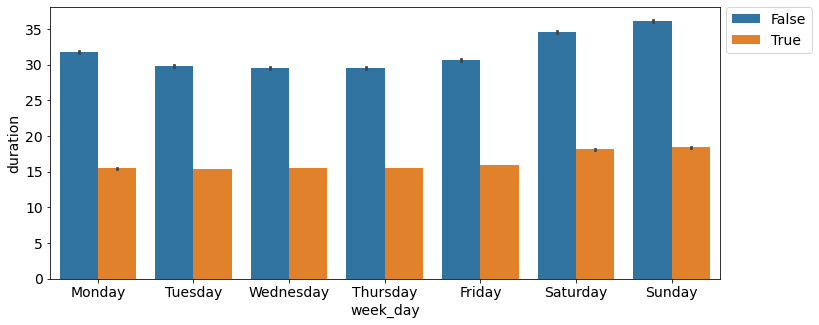

In [262]:
# relation between duration and biker type and week day
plt.figure(figsize=[12,5])
sb.barplot(data = df, x = 'week_day', y = 'duration', hue = 'is_member')
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0);

> Casual bikers trips at weekend has slightly higher duration in average.

**What is the average duration of a trip per month by type of rider?**

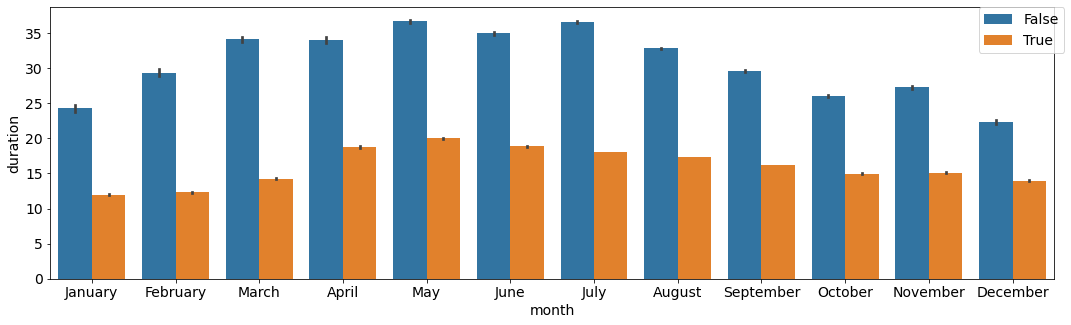

In [264]:
# relation between duration and biker type and month
plt.figure(figsize=[18,5])
sb.barplot(data = df, x = 'month', y = 'duration', hue = 'is_member')
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0);

> Casual bikers trips in summer has a much higher duration on average.

**What is the average duration of a trip per day part by type of rider?**

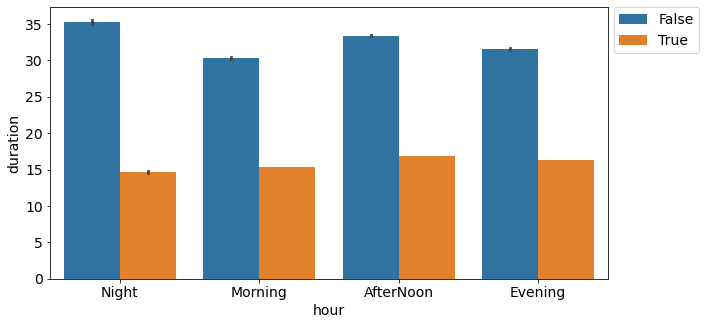

In [271]:
# relation between duration and biker type and day parts
plt.figure(figsize=[10,5])
sb.barplot(data = day_parts, x = 'hour', y = 'duration', hue = 'is_member')
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0);

> Casual bikers trips at night has slightly higher duration in average.

**What is the average duration of a trip per week day by type of bike?**

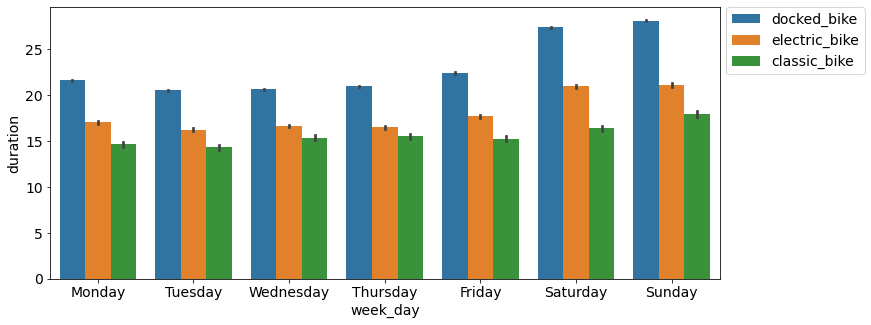

In [282]:
# relation between duration and bike type and week day
plt.figure(figsize=[12,5])
sb.barplot(data = df, x = 'week_day', y = 'duration', hue = 'rideable_type')
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0);

>Trip duration at weekend is much higher for all types of bikes.

**What is the average duration of a trip per month by type of bike?**

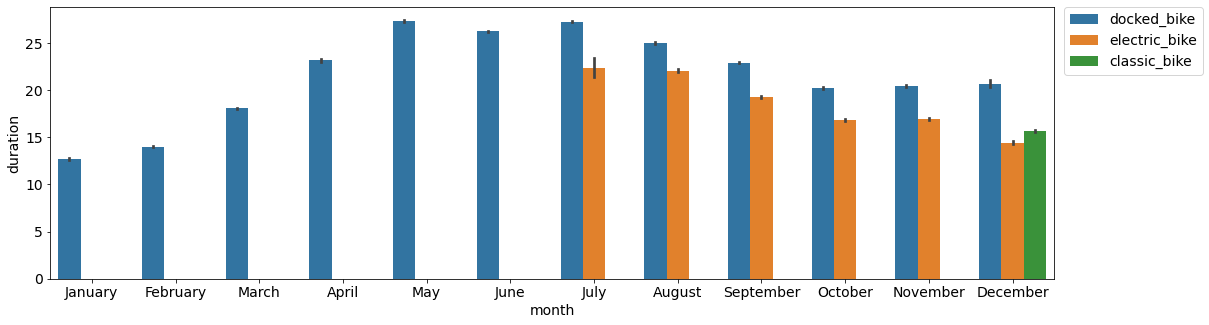

In [281]:
# relation between duration and bike type and month
plt.figure(figsize=[18,5])

sb.barplot(data = df, x = 'month', y = 'duration', hue = 'rideable_type')
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0);

>At the first half of the year till June ther is no use of electeric and classic bikes, Starting from july electric bikes starts to apper with average duratoin less than docked, probably becaue The demand of bikes usage is increasing in summer and docked bikes not covering that demand, However in December riders start to us classic bike even if the demand of bikes usage is much less than summer monthes.

**What is the average duration of a trip per day part by type of bike?**

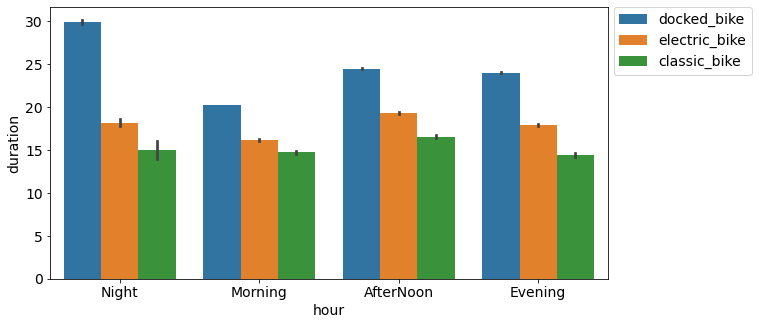

In [284]:
# relation between duration and bike type and day parts
plt.figure(figsize=[10,5])
sb.barplot(data = day_parts, x = 'hour', y = 'duration', hue = 'rideable_type')
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0);

>Trip duration of docked bikes increased at night by much.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

I extended my investigation of duration against time in terms of month, week day and day part by looking at the impact of is_member and rideable_type features. The multivariate exploration here showed that duration increases in cases when the user is not a member and the bike used is of a docked type especially at night, weekens and summer.

### Were there any interesting or surprising interactions between features?
Finding out that classic bikes used only in December and no other type but docked used from January to June was sort of a surprise.

In [288]:
#df.to_csv('data.csv', index=False)

In [289]:
#stations.to_csv('stations.csv', index=False)